# **Preprocessing**

Check data set sizes and features and compare

In [1]:
import pandas as pd
from pathlib import Path

# Your uploaded file paths (local to this environment)
f1 = Path("../data/dataset/1429_1.csv")
f2 = Path("../data/dataset/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv")
f3 = Path("../data/dataset/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv")

files = [f1, f2, f3]

dfs = {}
for f in files:
    df = pd.read_csv(f, low_memory=False)
    dfs[f.name] = df
    print(f"{f.name}: shape={df.shape}")


1429_1.csv: shape=(34660, 21)
Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv: shape=(5000, 24)
Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv: shape=(28332, 24)


In [2]:
col_sets = {name: set(df.columns) for name, df in dfs.items()}
all_cols = sorted(set().union(*col_sets.values()))

comparison = pd.DataFrame({
    "column": all_cols,
    **{name: [c in col_sets[name] for c in all_cols] for name in dfs.keys()}
})

display(comparison)

# Differences only (high signal)
diff_only = comparison[
    comparison[list(dfs.keys())[0]] != comparison[list(dfs.keys())[1]]
]  # quick first diff
display(diff_only.head(50))


,column,1429_1.csv,Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv,Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv
0,asins,True,True,True
1,brand,True,True,True
2,categories,True,True,True
3,dateAdded,False,True,True
4,dateUpdated,False,True,True
5,id,True,True,True
6,imageURLs,False,True,True
7,keys,True,True,True
8,manufacturer,True,True,True
9,manufacturerNumber,False,True,True


,column,1429_1.csv,Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv,Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv
3,dateAdded,False,True,True
4,dateUpdated,False,True,True
6,imageURLs,False,True,True
9,manufacturerNumber,False,True,True
11,primaryCategories,False,True,True
15,reviews.didPurchase,True,False,True
23,reviews.userCity,True,False,False
24,reviews.userProvince,True,False,False
26,sourceURLs,False,True,True


In [3]:
# Columns that commonly cause type mismatch; cast to string for safe stitching
force_str = [
    "id","asins","keys","name","brand","categories","primaryCategories",
    "reviews.text","reviews.title","reviews.username","reviews.date",
    "reviews.dateSeen","reviews.sourceURLs"
]

def coerce_common_types(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for c in force_str:
        if c in df.columns:
            df[c] = df[c].astype("string")
    return df

dfs_typed = {name: coerce_common_types(df) for name, df in dfs.items()}


In [4]:
# Add provenance so you can track issues later
dfs_ready = []
for name, df in dfs_typed.items():
    d = df.copy()
    d["source_file"] = name
    dfs_ready.append(d)

df_all = pd.concat(dfs_ready, ignore_index=True, sort=False)

print("Combined shape:", df_all.shape)
print("Combined columns:", len(df_all.columns))
display(df_all["source_file"].value_counts().to_frame("rows"))


Combined shape: (67992, 28)
Combined columns: 28


,rows
source_file,
1429_1.csv,34660
Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv,28332
Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv,5000


In [5]:
key_cols = [c for c in ["id", "asins", "keys"] if c in df_all.columns]
print("Key columns present:", key_cols)

summary = []
for c in key_cols:
    s = df_all[c]
    summary.append({
        "col": c,
        "missing_%": round(s.isna().mean() * 100, 3),
        "n_unique": s.nunique(dropna=True),
        "example_values": s.dropna().astype(str).head(3).tolist()
    })

display(pd.DataFrame(summary))

# Check multi-ASIN cells (comma-separated)
if "asins" in df_all.columns:
    asins_str = df_all["asins"].fillna("").astype(str)
    multi = asins_str.str.contains(",", regex=False)
    print("Rows where 'asins' contains multiple ASINs:", int(multi.sum()))
    if multi.any():
        display(df_all.loc[multi, ["source_file","id","asins","keys"]].head(15))


Key columns present: ['id', 'asins', 'keys']


,col,missing_%,n_unique,example_values
0,id,0.000,92,"[AVqkIhwDv8e3D1O-lebb, AVqkIhwDv8e3D1O-lebb, A..."
1,asins,0.003,94,"[B01AHB9CN2, B01AHB9CN2, B01AHB9CN2]"
2,keys,0.000,116,"[841667104676,amazon/53004484,amazon/b01ahb9cn..."


Rows where 'asins' contains multiple ASINs: 21219


,source_file,id,asins,keys
21952,1429_1.csv,AVpfl8cLLJeJML43AE3S,"B00L9EPT8O,B01E6AO69U","echowhite/263039693056,echowhite/152558276095,..."
21953,1429_1.csv,AVpfl8cLLJeJML43AE3S,"B00L9EPT8O,B01E6AO69U","echowhite/263039693056,echowhite/152558276095,..."
21954,1429_1.csv,AVpfl8cLLJeJML43AE3S,"B00L9EPT8O,B01E6AO69U","echowhite/263039693056,echowhite/152558276095,..."
21955,1429_1.csv,AVpfl8cLLJeJML43AE3S,"B00L9EPT8O,B01E6AO69U","echowhite/263039693056,echowhite/152558276095,..."
21956,1429_1.csv,AVpfl8cLLJeJML43AE3S,"B00L9EPT8O,B01E6AO69U","echowhite/263039693056,echowhite/152558276095,..."
21957,1429_1.csv,AVpfl8cLLJeJML43AE3S,"B00L9EPT8O,B01E6AO69U","echowhite/263039693056,echowhite/152558276095,..."
21958,1429_1.csv,AVpfl8cLLJeJML43AE3S,"B00L9EPT8O,B01E6AO69U","echowhite/263039693056,echowhite/152558276095,..."
21959,1429_1.csv,AVpfl8cLLJeJML43AE3S,"B00L9EPT8O,B01E6AO69U","echowhite/263039693056,echowhite/152558276095,..."
21960,1429_1.csv,AVpfl8cLLJeJML43AE3S,"B00L9EPT8O,B01E6AO69U","echowhite/263039693056,echowhite/152558276095,..."
21961,1429_1.csv,AVpfl8cLLJeJML43AE3S,"B00L9EPT8O,B01E6AO69U","echowhite/263039693056,echowhite/152558276095,..."


In [6]:
from pathlib import Path

out_csv = Path("../data/user_reviews.csv")
out_gz  = Path("../data/user_reviews.csv.gz")

# plain CSV
df_all.to_csv(out_csv, index=False, encoding="utf-8")

# compressed CSV (recommended if big)
df_all.to_csv(out_gz, index=False, encoding="utf-8", compression="gzip")

print("Saved:", out_csv)
print("Saved:", out_gz)



Saved: ..\data\user_reviews.csv
Saved: ..\data\user_reviews.csv.gz


Inspect our large and complete dataset.

In [7]:
# Load completed dataset and check shape
import pandas as pd
from pathlib import Path

PATH_GZ  = Path("../data/user_reviews.csv.gz")
PATH_CSV = Path("../data/user_reviews.csv")

path = PATH_GZ if PATH_GZ.exists() else PATH_CSV
df = pd.read_csv(path, low_memory=False)

print("Loaded:", path)
print("Shape:", df.shape)


Loaded: ..\data\user_reviews.csv.gz
Shape: (67992, 28)


In [8]:
# show columns
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_colwidth", 80)

print("Columns (count={}):".format(len(df.columns)))
print(df.columns.tolist())

display(df.head(8))


Columns (count=28):
['id', 'name', 'asins', 'brand', 'categories', 'keys', 'manufacturer', 'reviews.date', 'reviews.dateAdded', 'reviews.dateSeen', 'reviews.didPurchase', 'reviews.doRecommend', 'reviews.id', 'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs', 'reviews.text', 'reviews.title', 'reviews.userCity', 'reviews.userProvince', 'reviews.username', 'source_file', 'dateAdded', 'dateUpdated', 'primaryCategories', 'imageURLs', 'manufacturerNumber', 'sourceURLs']


,id,name,asins,brand,categories,keys,manufacturer,reviews.date,reviews.dateAdded,reviews.dateSeen,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,source_file,dateAdded,dateUpdated,primaryCategories,imageURLs,manufacturerNumber,sourceURLs
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offe...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Tablets,Tablets,Computers & Tablets","841667104676,amazon/53004484,amazon/b01ahb9cn2,0841667104676,allnewfirehd8ta...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/reviews.htm?format=embedded&page=200...,This product so far has not disappointed. My children love to use it and I l...,Kindle,NaN,NaN,Adapter,1429_1.csv,NaN,NaN,NaN,NaN,NaN,NaN
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offe...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Tablets,Tablets,Computers & Tablets","841667104676,amazon/53004484,amazon/b01ahb9cn2,0841667104676,allnewfirehd8ta...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/reviews.htm?format=embedded&page=200...,great for beginner or experienced person. Bought as a gift and she loves it,very fast,NaN,NaN,truman,1429_1.csv,NaN,NaN,NaN,NaN,NaN,NaN
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offe...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Tablets,Tablets,Computers & Tablets","841667104676,amazon/53004484,amazon/b01ahb9cn2,0841667104676,allnewfirehd8ta...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/reviews.htm?format=embedded&page=200...,"Inexpensive tablet for him to use and learn on, step up from the NABI. He wa...",Beginner tablet for our 9 year old son.,NaN,NaN,DaveZ,1429_1.csv,NaN,NaN,NaN,NaN,NaN,NaN
3,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offe...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Tablets,Tablets,Computers & Tablets","841667104676,amazon/53004484,amazon/b01ahb9cn2,0841667104676,allnewfirehd8ta...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,4.0,http://reviews.bestbuy.com/3545/5620406/reviews.htm?format=embedded&page=200...,I've had my Fire HD 8 two weeks now and I love it. This tablet is a great va...,Good!!!,NaN,NaN,Shacks,1429_1.csv,NaN,NaN,NaN,NaN,NaN,NaN
4,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offe...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Tablets,Tablets,Computers & Tablets","841667104676,amazon/53004484,amazon/b01ahb9cn2,0841667104676,allnewfirehd8ta...",Amazon,2017-01-12T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/reviews.htm?format=embedded&page=200...,I bought this for my grand daughter when she comes over to visit. I set it u...,Fantastic Tablet for kids,NaN,NaN,explore42,1429_1.csv,NaN,NaN,NaN,NaN,NaN,NaN
5,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offe...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Tablets,Tablets,Computers & Tablets","841667104676,amazon/53004484,amazon/b01ahb9cn2,0841667104676,allnewfirehd8ta...",Amazon,2017-01-12T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,5.0,http

In [ ]:
# Check data types and for empty data (% missing)

In [9]:
dtypes = df.dtypes.astype(str).to_frame("dtype")
missing = df.isna().sum().to_frame("missing_count")
missing["missing_%"] = (missing["missing_count"] / len(df) * 100).round(2)

profile = dtypes.join(missing).sort_values("missing_%", ascending=False)

display(profile.head(25))


,dtype,missing_count,missing_%
reviews.userProvince,float64,67992,100.00
reviews.userCity,float64,67992,100.00
reviews.didPurchase,object,67982,99.99
reviews.id,float64,67921,99.90
reviews.dateAdded,str,42901,63.10
dateUpdated,str,34660,50.98
imageURLs,str,34660,50.98
primaryCategories,str,34660,50.98
manufacturerNumber,str,34660,50.98
dateAdded,str,34660,50.98


In [10]:

# Most common categories (includes NaN)
df["categories"].value_counts(dropna=False).head(20)


categories
Fire Tablets,Tablets,Computers & Tablets,All Tablets,Electronics, Tech Toys, Movies, Music,Electronics,iPad & Tablets,Android Tablets,Frys                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    10966
AA,AAA,Health,Electronics,Health & Househ

We can see here that the top columns are redundant for not containing enough valuable data for our model and will be dropped from out feature set. Top 11 for sure are dropped, features that reveal the answers will be separated for model evaluation not added to X data split. These are : reviews.rating, reviews.numhelpful and reviews.doReconmmend.

In [10]:
# Check to see if there is any empty reviews in the data set by checking the length of them.

TEXT_COL = "reviews.text"
if TEXT_COL in df.columns:
    tmp = df.copy()
    tmp["text_len"] = tmp[TEXT_COL].fillna("").astype(str).str.len()
    display(tmp.sort_values("text_len").head(8)[["id","asins","reviews.title","reviews.text","text_len","source_file"]]
            if "source_file" in tmp.columns else
            tmp.sort_values("text_len").head(8)[["id","asins","reviews.title","reviews.text","text_len"]])


,id,asins,reviews.title,reviews.text,text_len,source_file
3111,AVsRjfwAU2_QcyX9PHqe,B01J2G4VBG,Five Stars,NaN,0,1429_1.csv
41334,AVpgNzjwLJeJML43Kpxn,"B00QWO9P0O,B00LH3DMUO",Five Stars,F,1,Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv
48041,AVpe7xlELJeJML43ypLz,"B00QWO9P0O,B01IB83NZG,B00MNV8E0C",a,d,1,Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv
47250,AVpgNzjwLJeJML43Kpxn,"B00QWO9P0O,B00LH3DMUO",Three Stars,1,1,Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv
49932,AVpe7xlELJeJML43ypLz,"B00QWO9P0O,B01IB83NZG,B00MNV8E0C",Four Stars,ok,2,Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv
48113,AVpe7xlELJeJML43ypLz,"B00QWO9P0O,B01IB83NZG,B00MNV8E0C",Amazon Batteries,OK,2,Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv
49934,AVpe7xlELJeJML43ypLz,"B00QWO9P0O,B01IB83NZG,B00MNV8E0C",Four Stars,ok,2,Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv
43796,AVpgNzjwLJeJML43Kpxn,"B00QWO9P0O,B00LH3DMUO",Four Stars,ok,2,Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv


In [11]:
# Make a count of how many reviews are empty.

TEXT_COL = "reviews.text"

s = df[TEXT_COL]
is_null = s.isna()
is_empty = s.fillna("").astype(str).str.strip().eq("")

print("Null count:", int(is_null.sum()))
print("Empty/whitespace count:", int(is_empty.sum()))
print("Null %:", round(is_null.mean()*100, 2))
print("Empty %:", round(is_empty.mean()*100, 2))



Null count: 1
Empty/whitespace count: 1
Null %: 0.0
Empty %: 0.0


In [12]:
MIN_LEN = 15  # tweak

text_len = s.fillna("").astype(str).str.strip().str.len()
near_null = text_len < MIN_LEN

print(f"Near-null (len < {MIN_LEN}) count:", int(near_null.sum()))
print(f"Near-null %:", round(near_null.mean()*100, 2))

# optional: show the shortest examples
display(df.loc[near_null].assign(text_len=text_len[near_null]).sort_values("text_len").head(50)
        [["id","asins",TEXT_COL,"text_len"]])


Near-null (len < 15) count: 2020
Near-null %: 2.97


,id,asins,reviews.text,text_len
3111,AVsRjfwAU2_QcyX9PHqe,B01J2G4VBG,NaN,0
47250,AVpgNzjwLJeJML43Kpxn,"B00QWO9P0O,B00LH3DMUO",1,1
41334,AVpgNzjwLJeJML43Kpxn,"B00QWO9P0O,B00LH3DMUO",F,1
48041,AVpe7xlELJeJML43ypLz,"B00QWO9P0O,B01IB83NZG,B00MNV8E0C",d,1
49442,AVpe7xlELJeJML43ypLz,"B00QWO9P0O,B01IB83NZG,B00MNV8E0C",ok,2
51448,AVpe7xlELJeJML43ypLz,"B00QWO9P0O,B01IB83NZG,B00MNV8E0C",ok,2
49436,AVpe7xlELJeJML43ypLz,"B00QWO9P0O,B01IB83NZG,B00MNV8E0C",Ok,2
49438,AVpe7xlELJeJML43ypLz,"B00QWO9P0O,B01IB83NZG,B00MNV8E0C",ok,2
42720,AVpgNzjwLJeJML43Kpxn,"B00QWO9P0O,B00LH3DMUO",Ok,2
42719,AVpgNzjwLJeJML43Kpxn,"B00QWO9P0O,B00LH3DMUO",OK,2


Drop features we dont need

In [13]:
import pandas as pd
import re

df_work = df.copy().rename(columns={"id": "item_id"})

# Drop the columns empty or not suitible for our unsupervised learning.
DROP_COLS = [
    "asins",  # you decided to remove
    "reviews.userProvince",
    "reviews.userCity",
    "reviews.didPurchase",
    "reviews.id",
    "reviews.dateAdded",
    "dateUpdated",
    "imageURLs",
    "manufacturerNumber",
    "primaryCategories",
    "sourceURLs",
]

df_work = df_work.drop(columns=[c for c in DROP_COLS if c in df_work.columns])

print("Shape:", df_work.shape)
print("Columns:", df_work.columns.tolist())


Shape: (67992, 17)
Columns: ['item_id', 'name', 'brand', 'categories', 'keys', 'manufacturer', 'reviews.date', 'reviews.dateSeen', 'reviews.doRecommend', 'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs', 'reviews.text', 'reviews.title', 'reviews.username', 'source_file', 'dateAdded']


In [14]:
TEXT_COLS = [c for c in ["reviews.title", "reviews.text"] if c in df_work.columns]
EVAL_COLS = [c for c in ["reviews.rating", "reviews.doRecommend", "reviews.numHelpful"] if c in df_work.columns]

META_COLS = [c for c in ["brand", "name", "categories", "manufacturer", "keys", "source_file", "reviews.date", "reviews.dateSeen"]
             if c in df_work.columns]

df_model = df_work[["item_id"] + TEXT_COLS + META_COLS].copy()
df_eval  = df_work[["item_id"] + EVAL_COLS].copy()

print("df_model:", df_model.shape, "df_eval:", df_eval.shape)


df_model: (67992, 11) df_eval: (67992, 4)


In [15]:
import re

# Build text_model
title = df_model["reviews.title"].fillna("").astype(str) if "reviews.title" in df_model.columns else ""
text  = df_model["reviews.text"].fillna("").astype(str)  if "reviews.text" in df_model.columns else ""

df_model["text_model"] = (title.str.strip() + ". " + text.str.strip()).str.strip()
df_model["text_model"] = df_model["text_model"].str.replace(r"^\.\s*", "", regex=True)

# --- Option A: define no_comment from reviews.text ONLY ---
body = df_model["reviews.text"].fillna("").astype(str) if "reviews.text" in df_model.columns else ""
body_stripped = body.str.strip()

df_model["body_len"] = body_stripped.str.len()
df_model["no_comment"] = df_model["body_len"] <= 1  # your rule, applied to review body only

# Keep text_len for general inspection (but NOT for no_comment)
df_model["text_len"] = df_model["text_model"].str.len()

def normalize_text(s: str) -> str:
    s = (s or "").lower().strip()
    s = re.sub(r"\s+", " ", s)
    return s

df_model["text_norm"] = df_model["text_model"].astype(str).map(normalize_text)
df_model["dedupe_key"] = df_model["item_id"].astype(str) + "||" + df_model["text_norm"]

print("no_comment (body_len<=1):", int(df_model["no_comment"].sum()),
      f"({df_model['no_comment'].mean()*100:.3f}%)")
print("dup candidates:", int(df_model.duplicated(subset=["dedupe_key"]).sum()))

# Show shortest BODY examples to ensure no_comment applies.
display(
    df_model.sort_values("body_len").head(8)[
        ["item_id", "reviews.title", "reviews.text", "body_len", "text_len", "no_comment"]
    ]
)


no_comment (body_len<=1): 4 (0.006%)
dup candidates: 8135


,item_id,reviews.title,reviews.text,body_len,text_len,no_comment
3111,AVsRjfwAU2_QcyX9PHqe,Five Stars,NaN,0,11,True
41334,AVpgNzjwLJeJML43Kpxn,Five Stars,F,1,13,True
48041,AVpe7xlELJeJML43ypLz,a,d,1,4,True
47250,AVpgNzjwLJeJML43Kpxn,Three Stars,1,1,14,True
49932,AVpe7xlELJeJML43ypLz,Four Stars,ok,2,14,False
48113,AVpe7xlELJeJML43ypLz,Amazon Batteries,OK,2,20,False
49934,AVpe7xlELJeJML43ypLz,Four Stars,ok,2,14,False
43796,AVpgNzjwLJeJML43Kpxn,Four Stars,ok,2,14,False


create the df cluster

In [16]:
# check df rows after feature removal
keep_mask = ~df_model.duplicated(subset=["dedupe_key"], keep="first")

df_model_dedup = df_model.loc[keep_mask].copy()
df_eval_dedup  = df_eval.loc[df_model_dedup.index].copy()

print("Rows before:", len(df_model))
print("Rows after :", len(df_model_dedup))
print("Removed    :", len(df_model) - len(df_model_dedup))

# This is what gets vectorized later (text only)
df_cluster = df_model_dedup[df_model_dedup["no_comment"] == False].copy()

print("Cluster-eligible rows:", len(df_cluster))

print("item_id in df_cluster?", "item_id" in df_cluster.columns)



Rows before: 67992
Rows after : 59857
Removed    : 8135
Cluster-eligible rows: 59853
item_id in df_cluster? True


In [17]:
assert "item_id" in df_model.columns, df_model.columns.tolist()
assert "item_id" in df_model_dedup.columns, df_model_dedup.columns.tolist()
assert "item_id" in df_cluster.columns, df_cluster.columns.tolist()
print("✅ item_id present through df_cluster")


✅ item_id present through df_cluster


In [18]:
# Per item user review counts

qc = df_model_dedup.groupby("item_id").agg(
    reviews_total=("text_model", "size"),
    reviews_no_comment=("no_comment", "sum"),
).assign(
    reviews_usable=lambda x: x["reviews_total"] - x["reviews_no_comment"]
)

display(qc.sort_values("reviews_usable", ascending=False).head(15))
display(qc["reviews_usable"].describe())


,reviews_total,reviews_no_comment,reviews_usable
item_id,,,
AVphgVaX1cnluZ0-DR74,10966,0,10966
AVpgNzjwLJeJML43Kpxn,7586,2,7584
AVpfl8cLLJeJML43AE3S,6621,0,6621
AV1YE_muvKc47QAVgpwE,5056,0,5056
AVpe7xlELJeJML43ypLz,3445,1,3444
AV1YnRtnglJLPUi8IJmV,3176,0,3176
AVqkIhwDv8e3D1O-lebb,2818,0,2818
AVqVGWQDv8e3D1O-ldFr,2544,0,2544
AVqkIhxunnc1JgDc3kg_,2443,0,2443


count       92.000000
mean       650.576087
std       1704.714009
min          1.000000
25%          5.000000
50%         19.000000
75%        295.750000
max      10966.000000
Name: reviews_usable, dtype: float64

In [30]:
# Number of review per product count + labels

import pandas as pd

# Use your deduped model table if available (better)
base = df_model_dedup if "df_model_dedup" in globals() else df_model

# --- Create item_label with fallbacks ---
name = base["name"].fillna("").astype(str) if "name" in base.columns else ""
brand = base["brand"].fillna("").astype(str) if "brand" in base.columns else ""

tmp = base[["item_id"]].copy()
tmp["item_label"] = name.str.strip()
tmp.loc[tmp["item_label"].eq(""), "item_label"] = brand.str.strip()
tmp["item_label"] = tmp["item_label"].where(tmp["item_label"].ne(""), tmp["item_id"].astype(str))

# Choose one label per item_id (most frequent)
item_label_map = (
    tmp.groupby("item_id")["item_label"]
    .agg(lambda s: s.value_counts().index[0])
    .rename("item_label")
)

# --- Your QC table (assuming you already created qc earlier) ---
# If not, recompute quickly from base
if "qc" not in globals():
    qc = base.groupby("item_id").agg(
        reviews_total=("text_model", "size"),
        reviews_no_comment=("no_comment", "sum"),
    ).assign(
        reviews_usable=lambda x: x["reviews_total"] - x["reviews_no_comment"]
    )

qc_labeled = qc.join(item_label_map, on="item_id")

# Reorder columns nicely
qc_labeled = qc_labeled[["item_label", "reviews_total", "reviews_no_comment", "reviews_usable"]]

# Show the most review-rich items first
display(qc_labeled.sort_values("reviews_usable", ascending=False).head(30))


,item_label,reviews_total,reviews_no_comment,reviews_usable
item_id,,,,
AVphgVaX1cnluZ0-DR74,"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta",10966,0,10966
AVpgNzjwLJeJML43Kpxn,AmazonBasics AAA Performance Alkaline Batteries (36 Count),7586,2,7584
AVpfl8cLLJeJML43AE3S,"Echo (White),,,\r\nEcho (White),,,",6621,0,6621
AV1YE_muvKc47QAVgpwE,Amazon Fire Tv,5056,0,5056
AVpe7xlELJeJML43ypLz,AmazonBasics AA Performance Alkaline Batteries (48 Count) - Packaging May Vary,3445,1,3444
AV1YnRtnglJLPUi8IJmV,Amazon Kindle Paperwhite - eBook reader - 4 GB - 6 monochrome Paperwhite - t...,3176,0,3176
AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offe...",2818,0,2818
AVqVGWQDv8e3D1O-ldFr,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offe...",2544,0,2544
AVqkIhxunnc1JgDc3kg_,"Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Tangerine - with Special O...",2443,0,2443


## **Model**
Type: K-Means + TF-IDF (90/10 split)

In [2]:
# Focus on products with enouth reviews to ensure the model can cluster well with K-Means

MIN_REVIEWS = 30  # adjust after looking at qc["reviews_usable"].describe()

counts = df_cluster["item_id"].value_counts()
eligible_items = counts[counts >= MIN_REVIEWS].index

df_cluster_eligible = df_cluster[df_cluster["item_id"].isin(eligible_items)].copy()

print("Eligible items:", len(eligible_items))
print("Eligible rows:", len(df_cluster_eligible))


NameError: name 'df_cluster' is not defined

In [33]:
# 90/10 model split for Unsupervised learning


import numpy as np

rng = np.random.default_rng(42)


def split_group(g, test_frac=0.10):
    n = len(g)
    test_n = max(1, int(round(n * test_frac)))
    idx = g.index.to_numpy()
    test_idx = rng.choice(idx, size=test_n, replace=False)

    out = g.copy()
    out["split"] = "train"
    out.loc[test_idx, "split"] = "test"
    return out


parts = []
for item_id, g in df_cluster_eligible.groupby("item_id"):
    out = split_group(g, test_frac=0.10)
    out["item_id"] = item_id  # <-- use group key safely
    parts.append(out)

df_split = pd.concat(parts, axis=0)

print(df_split["split"].value_counts())
print("item_id in df_split?", "item_id" in df_split.columns)



split
train    53545
test      5947
Name: count, dtype: int64
item_id in df_split? True


In [34]:
print("df_cluster columns:", df_cluster.columns.tolist())
print("df_cluster index name(s):", df_cluster.index.names)
print("Does df_cluster have item_id column?", "item_id" in df_cluster.columns)
print("Does df_cluster have item_id in index?", "item_id" in df_cluster.index.names)


df_cluster columns: ['item_id', 'reviews.title', 'reviews.text', 'brand', 'name', 'categories', 'manufacturer', 'keys', 'source_file', 'reviews.date', 'reviews.dateSeen', 'text_model', 'body_len', 'no_comment', 'text_len', 'text_norm', 'dedupe_key']
df_cluster index name(s): [None]
Does df_cluster have item_id column? True
Does df_cluster have item_id in index? False


In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

#TF-IDF Vectorizer

# using a Baseline configuration to begin with.

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    lowercase=True,
    stop_words="english",   # remove if your reviews are not mostly English
    ngram_range=(1,2),
    min_df=2,
    max_features=20000
)

train_mask = df_split["split"] == "train"
test_mask  = df_split["split"] == "test"

X_train = vectorizer.fit_transform(df_split.loc[train_mask, "text_model"])
X_test  = vectorizer.transform(df_split.loc[test_mask, "text_model"])

print("X_train:", X_train.shape, "X_test:", X_test.shape)


X_train: (53545, 20000) X_test: (5947, 20000)


In [36]:
from sklearn.cluster import KMeans
import pandas as pd

# Train/Test split

K = 3 #focus on creating 3 clusters (Negative/ Neutral / Positive)
results = []

train_df = df_split[df_split["split"]=="train"].copy()
test_df  = df_split[df_split["split"]=="test"].copy()

# We need row-to-matrix alignment
train_idx = train_df.index.to_numpy()
test_idx  = test_df.index.to_numpy()

# Create quick index->row position maps
train_pos = pd.Series(range(len(train_idx)), index=train_idx)
test_pos  = pd.Series(range(len(test_idx)), index=test_idx)

# Output columns
df_split["cluster"] = -1  # default

for item_id, g_train in train_df.groupby("item_id"):
    g_test = test_df[test_df["item_id"] == item_id]
    if len(g_train) < K:
        continue  # safety

    # Slice matrices for this item
    Xt = X_train[train_pos.loc[g_train.index].values]

    km = KMeans(n_clusters=K, random_state=42, n_init="auto")
    km.fit(Xt)

    # Assign train clusters
    df_split.loc[g_train.index, "cluster"] = km.labels_

    # Assign test clusters (if any)
    if len(g_test) > 0:
        Xv = X_test[test_pos.loc[g_test.index].values]
        df_split.loc[g_test.index, "cluster"] = km.predict(Xv)

print("Assigned clusters to rows:", (df_split["cluster"] >= 0).sum())

print("train rows:", len(train_df), "test rows:", len(test_df))
print("item_id in train_df?", "item_id" in train_df.columns)

Assigned clusters to rows: 59492
train rows: 53545 test rows: 5947
item_id in train_df? True


In [37]:
# check train before modeling
print(train_df.columns.tolist())

['item_id', 'reviews.title', 'reviews.text', 'brand', 'name', 'categories', 'manufacturer', 'keys', 'source_file', 'reviews.date', 'reviews.dateSeen', 'text_model', 'body_len', 'no_comment', 'text_len', 'text_norm', 'dedupe_key', 'split']


In [38]:
print("Assigned:", int((df_split["cluster"] >= 0).sum()))
print("Unassigned (-1):", int((df_split["cluster"] == -1).sum()))

# Cluster counts overall (exclude -1)
print("\nOverall cluster counts (assigned only):")
print(df_split[df_split["cluster"] >= 0]["cluster"].value_counts().sort_index())


Assigned: 59492
Unassigned (-1): 0

Overall cluster counts (assigned only):
cluster
0    15432
1    22812
2    21248
Name: count, dtype: int64


In [39]:
import pandas as pd

# Join ratings for evaluation (make sure df_eval_dedup aligns by index)
df_eval_view = df_split.join(df_eval_dedup[["reviews.rating"]], how="left")

# Use only rows with assigned clusters and non-null ratings
tmp = df_eval_view[(df_eval_view["cluster"] >= 0) & (df_eval_view["reviews.rating"].notna())].copy()

cluster_mean = tmp.groupby("cluster")["reviews.rating"].mean().sort_values()
print("Mean rating by cluster (low -> high):\n", cluster_mean)

# Lowest mean rating -> negative, middle -> neutral, highest -> positive
order = cluster_mean.index.tolist()
cluster_to_sentiment = {
    order[0]: "negative",
    order[1]: "neutral",
    order[2]: "positive",
}
print("\nCluster → sentiment mapping:", cluster_to_sentiment)

df_split["sentiment"] = df_split["cluster"].map(cluster_to_sentiment)


Mean rating by cluster (low -> high):
 cluster
1    4.495485
0    4.584824
2    4.586691
Name: reviews.rating, dtype: float64

Cluster → sentiment mapping: {1: 'negative', 0: 'neutral', 2: 'positive'}


In [40]:
agg = (
    df_split[df_split["cluster"] >= 0]
    .groupby(["item_id", "sentiment"])
    .size()
    .unstack(fill_value=0)
)

agg["total_reviews_used"] = agg.sum(axis=1)

# Percentages
for col in ["negative", "neutral", "positive"]:
    if col in agg.columns:
        agg[f"pct_{col}"] = (agg[col] / agg["total_reviews_used"] * 100).round(2)

# Optional label join (if you created item_label_map earlier)
if "item_label_map" in globals():
    agg = agg.join(item_label_map, on="item_id")

display(agg.sort_values("total_reviews_used", ascending=False).head(20))


,negative,neutral,positive,total_reviews_used,pct_negative,pct_neutral,pct_positive,item_label
item_id,,,,,,,,
AVphgVaX1cnluZ0-DR74,6452,1803,2711,10966,58.84,16.44,24.72,"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta"
AVpgNzjwLJeJML43Kpxn,2729,2228,2627,7584,35.98,29.38,34.64,AmazonBasics AAA Performance Alkaline Batteries (36 Count)
AVpfl8cLLJeJML43AE3S,1308,1509,3804,6621,19.76,22.79,57.45,"Echo (White),,,\r\nEcho (White),,,"
AV1YE_muvKc47QAVgpwE,1755,553,2748,5056,34.71,10.94,54.35,Amazon Fire Tv
AVpe7xlELJeJML43ypLz,1222,1119,1103,3444,35.48,32.49,32.03,AmazonBasics AA Performance Alkaline Batteries (48 Count) - Packaging May Vary
AV1YnRtnglJLPUi8IJmV,819,524,1833,3176,25.79,16.50,57.71,Amazon Kindle Paperwhite - eBook reader - 4 GB - 6 monochrome Paperwhite - t...
AVqkIhwDv8e3D1O-lebb,774,1592,452,2818,27.47,56.49,16.04,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offe..."
AVqVGWQDv8e3D1O-ldFr,1103,609,832,2544,43.36,23.94,32.70,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offe..."
AVqkIhxunnc1JgDc3kg_,755,1327,361,2443,30.90,54.32,14.78,"Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Tangerine - with Special O..."


In [45]:
### Final Model Schema ###

# 1) Core identifiers (keep for grouping / reporting, NOT in X)
ID_COLS = ["item_id"]

# 2) Text used for modeling (these are the ONLY columns that feed TF-IDF)
TEXT_COLS = ["text_model"]  # or ["text_norm"] if you want normalized text

# 3) Optional metadata to keep for later analysis/reporting (NOT in X)
META_COLS = [
    "brand", "name", "categories", "manufacturer", "keys",
    "source_file", "reviews.date", "reviews.dateSeen"
]

# 4) Eval-only columns (keep for scoring, NOT in X)
EVAL_COLS = ["reviews.rating"]
final_cols = [c for c in (ID_COLS + TEXT_COLS + META_COLS + EVAL_COLS + QC_COLS) if c in df_split.columns]
df_model = df_split[final_cols].copy()


# 5) QC columns (helps you debug cleaning decisions)
QC_COLS = ["text_len", "no_comment", "dedupe_key", "split"]

# Build final list, keeping only columns that exist
final_cols = [c for c in (ID_COLS + TEXT_COLS + META_COLS + EVAL_COLS + QC_COLS) if c in df_split.columns]

df_model = df_split[final_cols].copy()

print("FINAL df_model shape:", df_model.shape)
print("\nColumns used in TF-IDF (X):", TEXT_COLS)
print("Columns kept for grouping/reporting:", [c for c in ID_COLS if c in df_model.columns])
print("Eval-only columns (NOT in X):", [c for c in EVAL_COLS if c in df_model.columns])
print("\nFinal columns list:")
print(df_model.columns.tolist())

# Small preview (report-friendly)
preview_cols = [c for c in ["item_id", "text_model", "text_len", "no_comment", "split", "reviews.rating"] if
                c in df_model.columns]
display(df_model[preview_cols].head(8))


FINAL df_model shape: (59492, 14)

Columns used in TF-IDF (X): ['text_model']
Columns kept for grouping/reporting: ['item_id']
Eval-only columns (NOT in X): []

Final columns list:
['item_id', 'text_model', 'brand', 'name', 'categories', 'manufacturer', 'keys', 'source_file', 'reviews.date', 'reviews.dateSeen', 'text_len', 'no_comment', 'dedupe_key', 'split']


,item_id,text_model,text_len,no_comment,split
29573,AV1YE_muvKc47QAVgpwE,Better Than Amazon Fire Stick. The Amazon Fire TV works better and faster th...,191,False,train
29574,AV1YE_muvKc47QAVgpwE,It a good product. I like the product and would tell others about it.,69,False,train
29575,AV1YE_muvKc47QAVgpwE,"Good product. Really like the voice commands, including commands outside the...",225,False,train
29576,AV1YE_muvKc47QAVgpwE,Amazing product. Got it so I can have everything in one device and it does t...,155,False,train
29577,AV1YE_muvKc47QAVgpwE,Easy to use. Like the voice command option to search for shows I want to watch.,79,False,train
29578,AV1YE_muvKc47QAVgpwE,"Decent, but have to reset monthly. Decent, but have to reset monthly, i have...",225,False,train
29579,AV1YE_muvKc47QAVgpwE,Great equipment. Great purchase and good investment.Also wonderful viewing,74,False,train
29580,AV1YE_muvKc47QAVgpwE,great item to jailbreak. Follow the instruction on youtube and you can jailb...,133,False,train


) missing from font(s) DejaVu Sans.pykernel_110076\2265908562.py:48: UserWarning: Glyph 13 (
  plt.tight_layout()
C:\Users\Ben_h\AppData\Local\Temp\ipykernel_110076\2265908562.py:48: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
) missing from font(s) DejaVu Sans.on\Python314\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


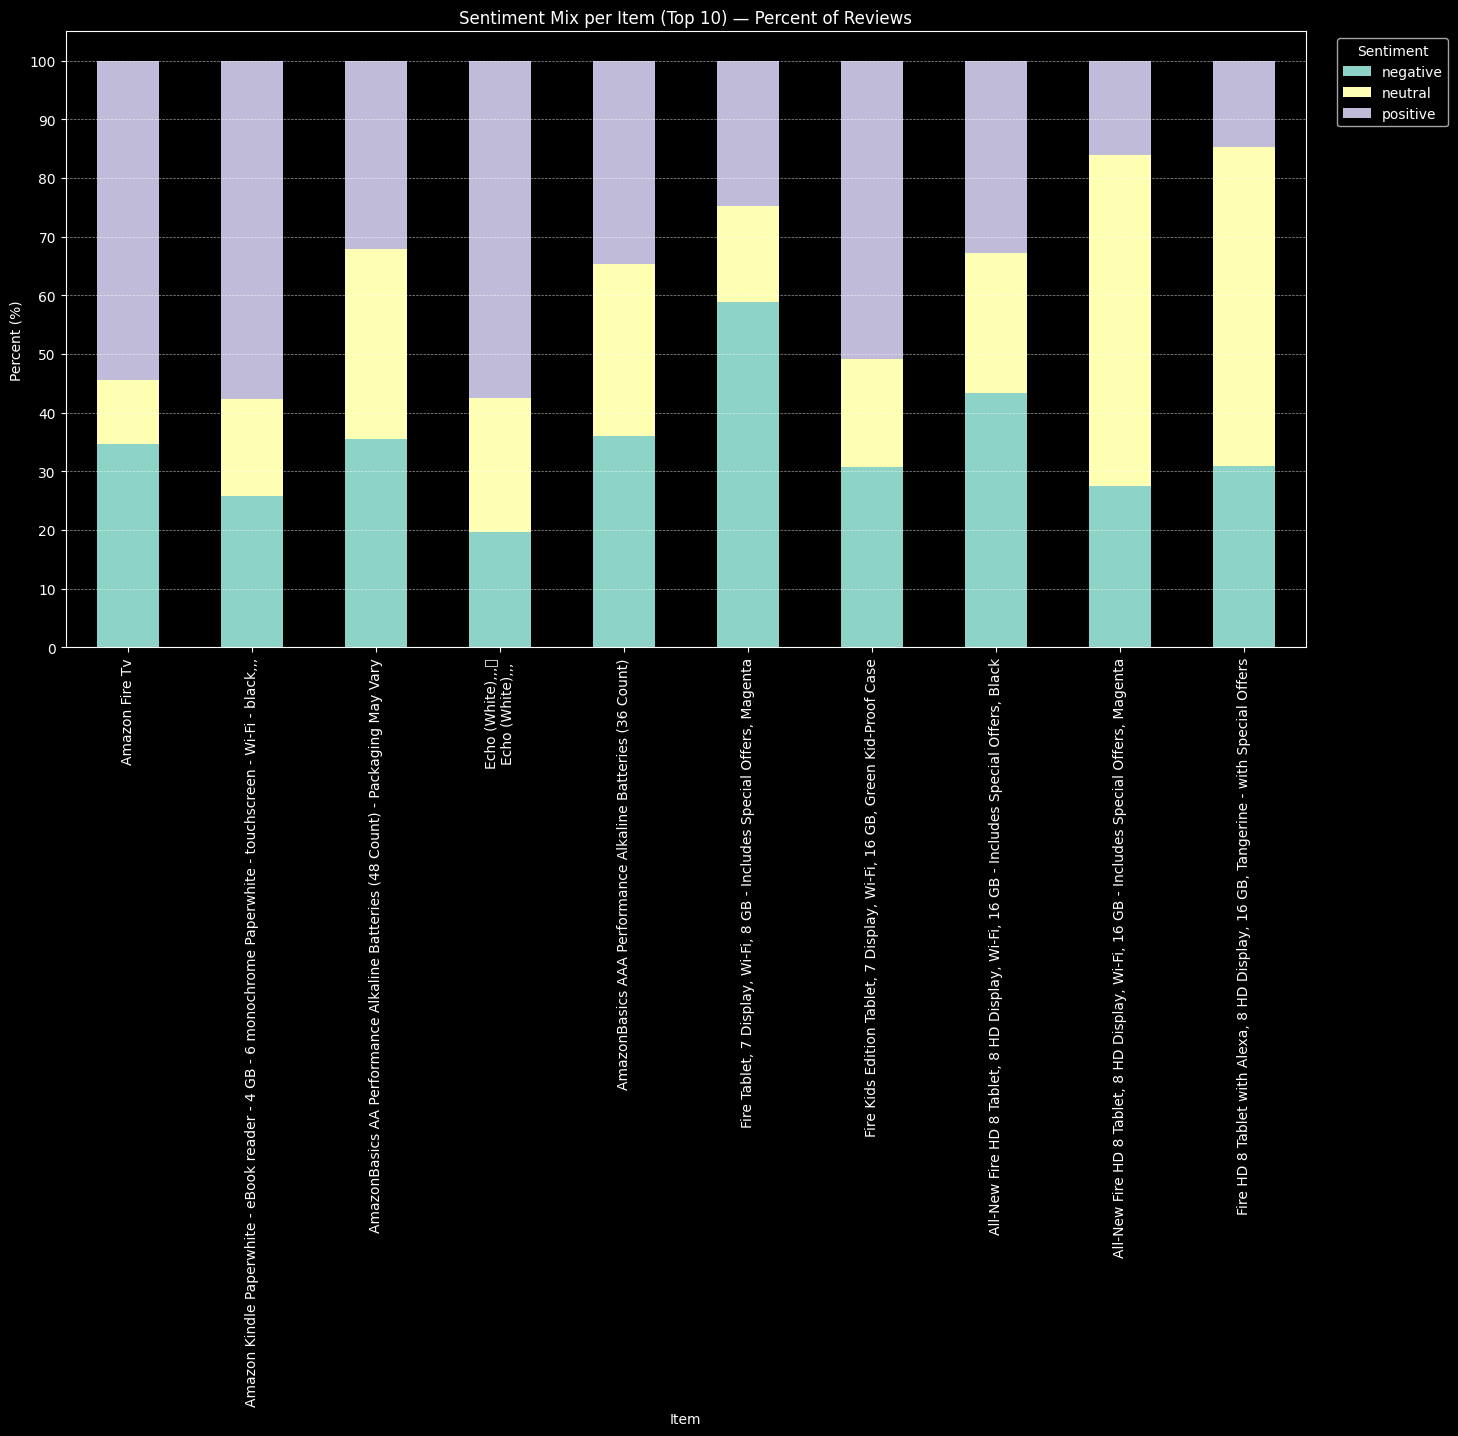

In [46]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

TOP_N = 10

# Make sure you already created df_split["sentiment"] from the cluster mapping step
df_plot = df_split[df_split["cluster"] >= 0].copy()

top_items = (
    df_plot.groupby("item_id").size()
    .sort_values(ascending=False)
    .head(TOP_N)
    .index
)

pivot_counts = (
    df_plot[df_plot["item_id"].isin(top_items)]
    .groupby(["item_id", "sentiment"])
    .size()
    .unstack(fill_value=0)
)

# Ensure consistent column order
for c in ["negative", "neutral", "positive"]:
    if c not in pivot_counts.columns:
        pivot_counts[c] = 0
pivot_counts = pivot_counts[["negative", "neutral", "positive"]]

# Convert to percentages (row-wise)
pivot_pct = pivot_counts.div(pivot_counts.sum(axis=1), axis=0) * 100

# Optional readable labels
if "item_label_map" in globals():
    pivot_pct = pivot_pct.join(item_label_map, on="item_id")
    pivot_pct = pivot_pct.set_index("item_label", drop=True)

ax = pivot_pct.plot(kind="bar", stacked=True, figsize=(16, 8))

ax.set_title(f"Sentiment Mix per Item (Top {TOP_N}) — Percent of Reviews")
ax.set_xlabel("Item")
ax.set_ylabel("Percent (%)")

# Tight, readable y-axis
ax.yaxis.set_major_locator(MultipleLocator(10))  # 0,10,20,...100
ax.grid(axis="y", linestyle="--", linewidth=0.5, alpha=0.6)

plt.legend(title="Sentiment", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [47]:
# Is this data true?

import numpy as np
import pandas as pd

# join ratings for evaluation
df_eval_view = df_split.join(df_eval_dedup[["reviews.rating"]], how="left").copy()

def rating_to_sentiment(r):
    if pd.isna(r):
        return np.nan
    r = float(r)
    if r <= 2:
        return "negative"
    if r == 3:
        return "neutral"
    return "positive"

df_eval_view["true_sentiment"] = df_eval_view["reviews.rating"].map(rating_to_sentiment)

tmp = df_eval_view[(df_eval_view["cluster"] >= 0) & df_eval_view["reviews.rating"].notna()].copy()

cluster_mean = tmp.groupby("cluster")["reviews.rating"].mean().sort_values()
order = cluster_mean.index.tolist()

cluster_to_sentiment = {order[0]:"negative", order[1]:"neutral", order[2]:"positive"}
print("Cluster means:\n", cluster_mean)
print("Mapping:", cluster_to_sentiment)

df_eval_view["pred_sentiment"] = df_eval_view["cluster"].map(cluster_to_sentiment)


Cluster means:
 cluster
1    4.495485
0    4.584824
2    4.586691
Name: reviews.rating, dtype: float64
Mapping: {1: 'negative', 0: 'neutral', 2: 'positive'}


In [50]:
import numpy as np
import pandas as pd

# join ratings for evaluation
df_eval_view = df_split.join(df_eval_dedup[["reviews.rating"]], how="left").copy()

def rating_to_sentiment(r):
    if pd.isna(r): return np.nan
    r = float(r)
    if r <= 2: return "negative"
    if r == 3: return "neutral"
    return "positive"

df_eval_view["true_sentiment"] = df_eval_view["reviews.rating"].map(rating_to_sentiment)

# only rows we can evaluate
tmp = df_eval_view[(df_eval_view["cluster"] >= 0) & df_eval_view["reviews.rating"].notna()].copy()

# per-item mapping: cluster -> sentiment based on mean rating within that item
maps = []
for item_id, g in tmp.groupby("item_id"):
    means = g.groupby("cluster")["reviews.rating"].mean().sort_values()
    if len(means) < 3:
        continue
    order = means.index.tolist()
    maps.append(pd.DataFrame({
        "item_id": [item_id]*3,
        "cluster": order,
        "pred_sentiment": ["negative","neutral","positive"]
    }))

map_df = pd.concat(maps, ignore_index=True)

# attach per-item mapping to each row
df_eval_view = df_eval_view.merge(map_df, on=["item_id","cluster"], how="left")



In [53]:
from sklearn.metrics import f1_score, accuracy_score
import pandas as pd
import numpy as np

# ---------- Settings ----------
N_PRODUCTS_SAMPLE = 8      # how many products to display examples for
MAX_CHARS = 220            # truncate review text for display
RANDOM_SEED = 42

TEXT_COL = "text_model" if "text_model" in eval_df.columns else "text_norm"

# ---------- 1) Per-product scores ----------
per_item = (
    eval_df.groupby("item_id")
    .apply(lambda g: pd.Series({
        "n": len(g),
        "acc": accuracy_score(g["true_sentiment"], g["pred_sentiment"]),
        "f1_macro": f1_score(g["true_sentiment"], g["pred_sentiment"], average="macro")
    }))
    .reset_index()
)

# Quick “best/worst” tables
print("Per-product score snapshots")
display(per_item.sort_values("f1_macro").head(10))
display(per_item.sort_values("f1_macro", ascending=False).head(10))

print("\nPer-product score distribution (all products)")
print(per_item[["n","acc","f1_macro"]].describe())

print("\nMean / Median Macro F1 across products:")
print("mean_f1_macro =", round(per_item["f1_macro"].mean(), 4))
print("median_f1_macro =", round(per_item["f1_macro"].median(), 4))


# ---------- 2) Random example reviews per product (pred NEG and pred POS) ----------
rng = np.random.default_rng(RANDOM_SEED)

sample_items = per_item["item_id"].drop_duplicates()
if len(sample_items) > N_PRODUCTS_SAMPLE:
    sample_items = rng.choice(sample_items.to_numpy(), size=N_PRODUCTS_SAMPLE, replace=False)

sample_items = pd.Index(sample_items)

# Helper: pick a random row from a subset, else return blanks
def pick_random_row(df_sub, label):
    if len(df_sub) == 0:
        return pd.Series({
            f"{label}_true": None,
            f"{label}_pred": None,
            f"{label}_text": None
        })
    row = df_sub.sample(1, random_state=int(rng.integers(0, 1_000_000))).iloc[0]
    txt = str(row.get(TEXT_COL, ""))
    txt = txt.replace("\n", " ").strip()
    txt = txt[:MAX_CHARS] + ("..." if len(txt) > MAX_CHARS else "")
    return pd.Series({
        f"{label}_true": row["true_sentiment"],
        f"{label}_pred": row["pred_sentiment"],
        f"{label}_text": txt
    })

rows = []
for item_id in sample_items:
    g = eval_df[eval_df["item_id"] == item_id]

    # predicted negative / positive examples (model perspective)
    neg = g[g["pred_sentiment"] == "negative"]
    pos = g[g["pred_sentiment"] == "positive"]

    neg_ex = pick_random_row(neg, "predNEG")
    pos_ex = pick_random_row(pos, "predPOS")

    # attach product metrics
    metrics = per_item[per_item["item_id"] == item_id].iloc[0]

    rows.append(pd.Series({
        "item_id": item_id,
        "n": int(metrics["n"]),
        "acc": round(float(metrics["acc"]), 4),
        "f1_macro": round(float(metrics["f1_macro"]), 4),
        **neg_ex.to_dict(),
        **pos_ex.to_dict(),
    }))

examples_table = pd.DataFrame(rows)

print(f"\nRandom per-product examples (showing {len(examples_table)} products)")
display(
    examples_table[
        ["item_id","n","acc","f1_macro",
         "predNEG_true","predNEG_pred","predNEG_text",
         "predPOS_true","predPOS_pred","predPOS_text"]
    ].sort_values("f1_macro")
)

# ---------- 3) Overall (row-level) macro F1 for reference ----------
overall_macro_f1 = f1_score(eval_df["true_sentiment"], eval_df["pred_sentiment"], average="macro")
overall_acc = accuracy_score(eval_df["true_sentiment"], eval_df["pred_sentiment"])

print("\nOverall row-level evaluation (reference only; product-first is the main metric):")
print("overall_acc =", round(overall_acc, 4))
print("overall_macro_f1 =", round(overall_macro_f1, 4))



Per-product score snapshots


,item_id,n,acc,f1_macro
38,AVzYlGnuGV-KLJ3abPUD,82.0,0.121951,0.084614
32,AVsRjfwAU2_QcyX9PHqe,401.0,0.137157,0.114914
29,AVqkIhxunnc1JgDc3kg_,2443.0,0.169873,0.118813
10,AVpgdkC8ilAPnD_xsvyi,1031.0,0.171678,0.120976
28,AVqkIhwDv8e3D1O-lebb,2818.0,0.183463,0.124891
39,AWFUWc8THh53nbDRF6YO,650.0,0.189231,0.130331
20,AVqVGZO3nnc1JgDc3jGK,68.0,0.191176,0.133041
18,AVqVGZN9QMlgsOJE6eUZ,63.0,0.206349,0.138889
21,AVqVGZQBQMlgsOJE6eUb,62.0,0.258065,0.140351
33,AVwjfXp4QMlgsOJE8qmk,233.0,0.193133,0.145825


,item_id,n,acc,f1_macro
41,AWMjT0WguC1rwyj_rFh3,590.0,0.735593,0.288656
22,AVqVGZSEQMlgsOJE6eUc,304.0,0.460526,0.277769
3,AVpe7xlELJeJML43ypLz,3444.0,0.365273,0.275317
5,AVpfl8cLLJeJML43AE3S,6621.0,0.556411,0.267268
15,AVpjEN4jLJeJML43rpUe,1042.0,0.498081,0.257537
9,AVpgNzjwLJeJML43Kpxn,7584.0,0.343882,0.255685
2,AV1YnRtnglJLPUi8IJmV,3176.0,0.564547,0.254453
0,AV1YE_muvKc47QAVgpwE,5056.0,0.520174,0.240537
16,AVqVGWLKnnc1JgDc3jF1,1695.0,0.456637,0.230511
4,AVpfIfGA1cnluZ0-emyp,73.0,0.273973,0.217593



Per-product score distribution (all products)
                  n        acc   f1_macro
count     42.000000  42.000000  42.000000
mean    1416.476190   0.306697   0.185835
std     2311.772831   0.128526   0.050503
min       30.000000   0.121951   0.084614
25%      159.250000   0.212254   0.150927
50%      386.500000   0.284048   0.180543
75%     1632.750000   0.342663   0.217337
max    10966.000000   0.735593   0.288656

Mean / Median Macro F1 across products:
mean_f1_macro = 0.1858
median_f1_macro = 0.1805

Random per-product examples (showing 8 products)


,item_id,n,acc,f1_macro,predNEG_true,predNEG_pred,predNEG_text,predPOS_true,predPOS_pred,predPOS_text
4,AVzYlGnuGV-KLJ3abPUD,82,0.1220,0.0846,positive,negative,Good. Ok for the price product is ok not bad easy to use,positive,positive,its not the best but works well. overall its ok just make sure you have a me...
1,AVqkIhxunnc1JgDc3kg_,2443,0.1699,0.1188,positive,negative,"Good gift. Nice tablet, great price for the product makes a good gift for so...",positive,positive,Great Value. My wife loves her new Fire 8 tablet. It is easy to use and rubs...
0,AWK8z0pOIwln0LfXlSxH,196,0.2143,0.1502,positive,negative,Very useful. This product will for sure come in handy. Very easy to use. Pre...,positive,positive,Great Product!. Love it Love it Love it!!!!!!!!!!!!!!!!!!!!!!!!!!!
7,AVqkIhkhv8e3D1O-lebZ,89,0.3146,0.1707,positive,negative,Wife absolutley loves her new Fire HD 8 tablet. Bought a Fire HD 8 tablet fo...,positive,positive,Great. Love my mine! Works great with prime! And I have all my best movies!
3,AVqkIdntQMlgsOJE6fuB,30,0.2667,0.1809,positive,negative,"Great eReader. El libro electrnico es muy prctico, puedes tener todos los li...",positive,positive,"Good, but one small thing annoys me.... Purchased this as an upgrade to the ..."
2,AVwjfXqqQMlgsOJE8qmm,293,0.3276,0.1993,positive,negative,Perfect tab for kids. Cheap and best tab for kids.Good qualitygreat features,positive,positive,Great learning device. We got this pad for my son who's 7. He absolutely lov...
5,AVqVGWLKnnc1JgDc3jF1,1695,0.4566,0.2305,positive,negative,Perfect Gift for kids. I bought this for my 8 year olds birthday. It is perf...,negative,positive,"Not good. Super slow, not of decent quality.I would not buy another. Memory ..."
6,AVpe7xlELJeJML43ypLz,3444,0.3653,0.2753,positive,negative,Love!. Said it once and I'll say it again. Love Amazon batteries! Haven't be...,positive,positive,Five Stars. Order these all the time Good Price



Overall row-level evaluation (reference only; product-first is the main metric):
overall_acc = 0.3604
overall_macro_f1 = 0.2257


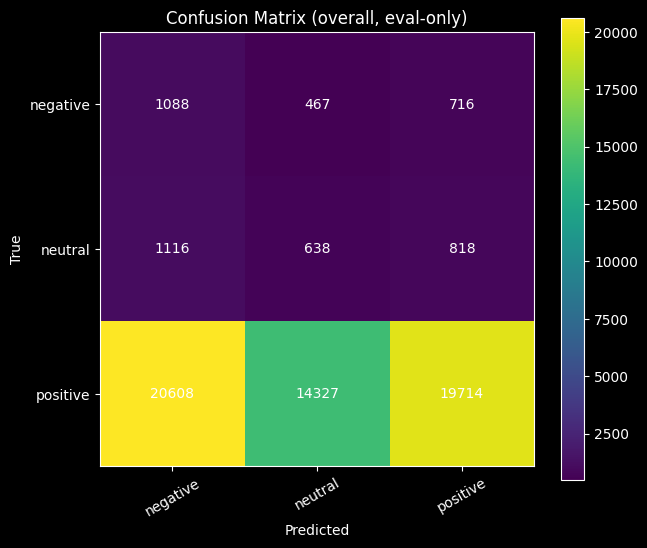

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

labels = ["negative","neutral","positive"]
cm = confusion_matrix(eval_df["true_sentiment"], eval_df["pred_sentiment"], labels=labels)

plt.figure(figsize=(7, 6))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (overall, eval-only)")
plt.xticks(range(len(labels)), labels, rotation=30)
plt.yticks(range(len(labels)), labels)

# annotate values
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")

plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.show()


**Final Verdict** Poor accuracy rating - Show that the model is focusing on the overall sentiment which introduces the mismatched data as well which could be the main reason for this issue.

This also shows that K-Meanns on TF-IDF did not cleanly separate sentiment; clusters appear influenced by review length/style and product vocabulary. Because the dataset is ~92% positive, global accuracy is not informative; minority-class performance (macro F1) remains low.